## Generate a timeseries from the data

First, crawl the instrument for all of the data for the past 30 days.


In [1]:
import requests, json
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
from tqdm import tqdm
import numpy as np

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-kg8xiwoh because the default path (/u/pdaniel/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


Create a loop to ping the server every 15 minutes and generate a list of the PIDs for the past month.

In [2]:
def format_datestr(date):
    '''format datetime object for url request'''
    return "T".join(str(date).split(" ")).split('.')[0]


def ping_ifcb(date):
    '''use the /api/nearest to build a list of APIs and times'''
    now = format_datestr(date)
    url = "http://128.114.25.154:8888/IFCB104/api/feed/nearest/" + now
    response = requests.get(url)
    if response.ok:
        return response.json()
    else:
        return None

    
def get_pids(stime, etime=None, delta_days = None):
    """Get pids by crawling the instrument server"""
    
    pids = []
    dates = []    
    
    if etime is None:
        if delta_days is None:
            etime = stime - dt.timedelta(days=30) 
        else:
            etime = stime - dt.timedelta(days=delta_days) 
            
    while (etime < stime):
        response = ping_ifcb(etime)
        
        if response is not None:
            pid = response['pid']
            date = response['date']
            if pid not in pids:
                pids.append(pid)
                dates.append(date)

        etime = etime + dt.timedelta(minutes=15)
    return pids, dates

In [3]:
now = dt.datetime.now()
pids, dates = get_pids(stime=now, delta_days=45)
print(len(pids))

2409


__Get auto classified data from each pid, filter and count it__

In [7]:
def get_classified_data(pid):
    """Get autoclass file and processes it for that bin"""
    autoclass_url = pid+"_class_scores.csv"
    df_autoclass = pd.read_csv(autoclass_url) # These are percentage of counts
    totals = df_autoclass.apply(lambda x: x == df_autoclass.max(axis=1)).sum()
    totals = totals.reset_index(name='counts')
    totals = totals.rename(columns={'index':'class'})
    totals = totals.sort_values(['counts']).reset_index(drop=True)
    totals = totals.drop(totals[totals['class'].isin(["pid", "Skeletonema",	"Thalassionema", "Thalassiosira", "unclassified"])].index)
    return totals, len(df_autoclass)

    
totals, nsamples = get_classified_data(pids[-1])

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.


In [10]:
for i in tqdm(range(len(pids))):
    totals, nsamples = get_classified_data(pids[i])
    if i == 0:
        column_names = list(totals["class"].unique())
        df = pd.DataFrame(columns=column_names, data=totals['counts'].values.reshape(1,24))
        df['dateTime'] = dates[i]
        df['nsamples'] = nsamples
    else:
        df_new = pd.DataFrame(columns=column_names, data=totals['counts'].values.reshape(1,24))
        df_new['dateTime'] = dates[i]
        df_new['nsamples'] = nsamples
        df = pd.concat((df,df_new))

df['dateTime'] = pd.to_datetime(df['dateTime'])
df.index = df['dateTime']
df.to_pickle("./data/2021-jul-22-tina")

100%|██████████| 2354/2354 [13:49<00:00,  2.84it/s]


__Reindex the data to add NANs were the data is missing__


In [3]:
df = pd.read_pickle("./data/2021-jul-22-tina")

In [25]:
new_index = pd.date_range(start=df['dateTime'].iloc[0],end=df['dateTime'].iloc[-1],freq="23T44S")
df_reindexed = df.reindex(new_index,method="nearest",tolerance='25min',limit=2) # reindex
df_reindexed

,Pseudo-nitzschia,Prorocentrum,Lingulodinium,Peridinium,Dinophysis,small_misc,Ceratium,Amy_Gony_Protoc,Cochlodinium,NanoP_less10,...,Guin_Dact,Cyl_Nitz,Pennate,Chaetoceros,Eucampia,Centric,Det_Cer_Lau,Cryptophyte,dateTime,nsamples
2021-06-06 07:22:15+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,7.0,7.0,8.0,13.0,14.0,20.0,20.0,100.0,2021-06-06 07:22:15+00:00,209.0
2021-06-06 07:45:59+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,7.0,7.0,8.0,13.0,14.0,20.0,20.0,100.0,2021-06-06 07:22:15+00:00,209.0
2021-06-06 08:09:43+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN
2021-06-06 08:33:27+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN
2021-06-06 08:57:11+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-07-21 15:32:39+00:00,0.0,0.0,0.0,0.0,0.0,0.0,1.0,4.0,7.0,13.0,...,36.0,47.0,69.0,69.0,70.0,81.0,123.0,133.0,2021-07-21 15:29:46+00:00,770.0
2021-07-21 15:56:23+00:00,0.0,0.0,0.0,0.0,1.0,1.0,1.0,2.0,4.0,4.0,...,34.0,49.0,55.0,58.0,64.0,68.0,93.0,129.0,2021-07-21 15:53:32+00:00,659.0
2021-07-21 16:20:07+00:00,0.0,0.0,0.0,1.0,1.0,2.0,3.0,3.0,3.0,7.0,...,39.0,42.0,45.0,49.0,69.0,85.0,95.0,103.0,2021-07-21 16:17:17+00:00,643.0
2021-07-21 16:43:51+00:00,0.0,0.0,0.0,0.0,0.0,1.0,2.0,3.0,5.0,7.0,...,31.0,37.0,42.0,62.0,71.0,81.0,88.0,103.0,2021-07-21 16:41:03+00:00,620.0


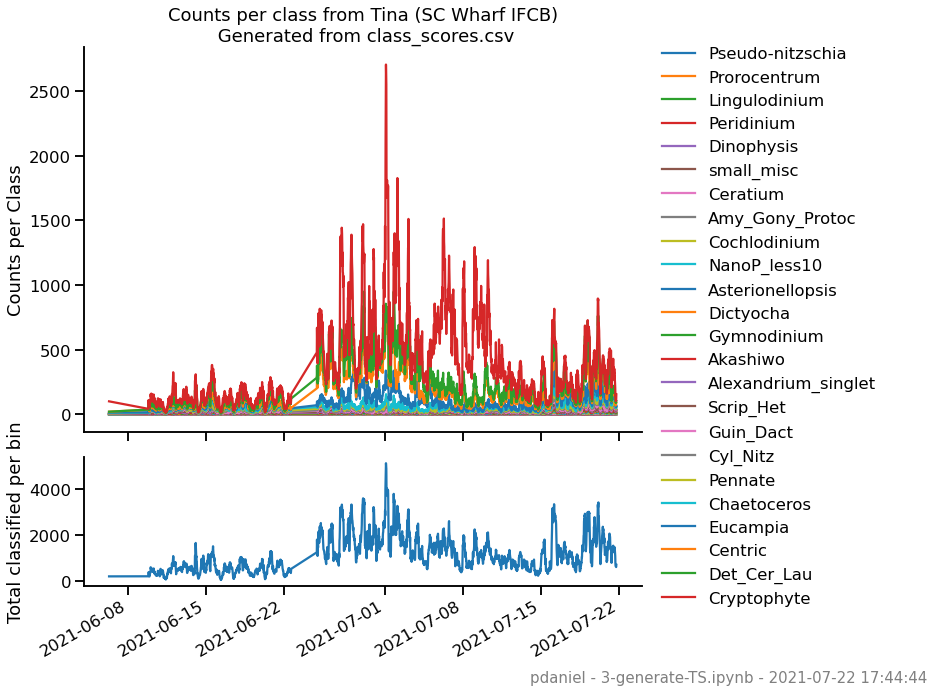

In [14]:
sns.set_context('talk')
fig, (ax,ax2) = plt.subplots(2,constrained_layout=False, gridspec_kw={'height_ratios': [3, 1]})
plt.subplots_adjust(hspace=.1)
fig.set_size_inches(10,11)

p1 = df[column_names].plot(ax=ax,)
ax.legend(bbox_to_anchor=(1.01, 1.04), loc='upper left',frameon=False)
ax.set_ylabel("Counts per Class")

ax2.plot(df['dateTime'], df['nsamples'])
ax2.set_ylabel("Total classified per bin")
fig.autofmt_xdate()

ax.set_title("Counts per class from Tina (SC Wharf IFCB)\n Generated from class_scores.csv")

ax2.text(.8,
         -.65,
         'pdaniel - 3-generate-TS.ipynb - {}'.format(str(dt.datetime.now())[:-7]),
         transform=ax.transAxes,
         fontsize='small',
         color='.5')

sns.despine()
# plt.savefig('./figures/all_data.png',dpi=300,bbox_inches='tight',transparent=False)


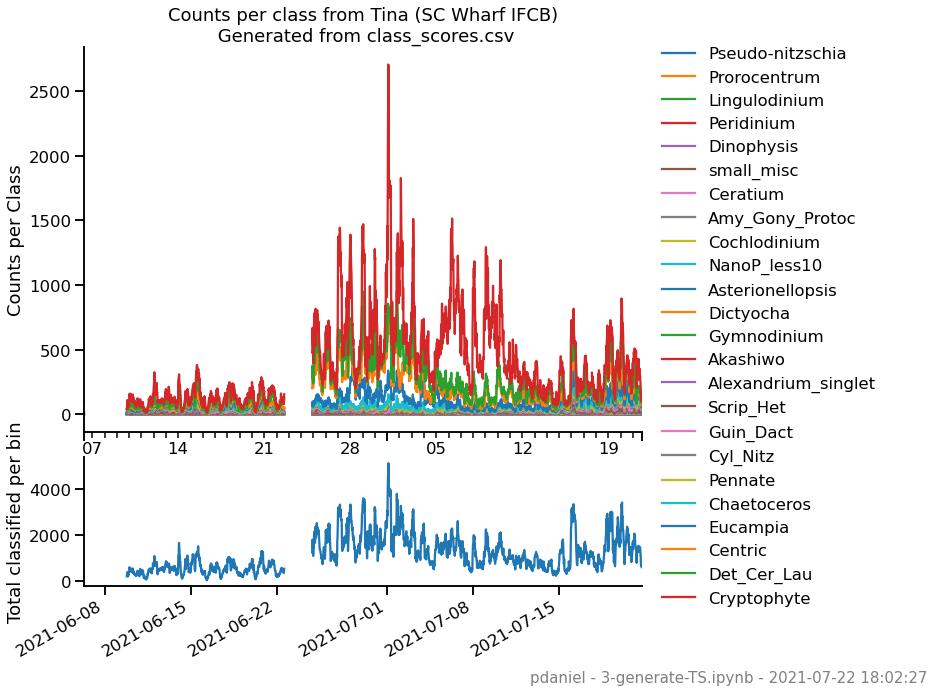

In [19]:
sns.set_context('talk')
fig, (ax,ax2) = plt.subplots(2,constrained_layout=False, gridspec_kw={'height_ratios': [3, 1]},sharex=False)
plt.subplots_adjust(hspace=.1)
fig.set_size_inches(10,11)

p1 = df_reindexed[column_names].plot(ax=ax,)
ax.legend(bbox_to_anchor=(1.01, 1.04), loc='upper left',frameon=False)
ax.set_ylabel("Counts per Class")

ax2.plot(df_reindexed['nsamples'])
ax2.set_ylabel("Total classified per bin")
fig.autofmt_xdate()

ax.set_title("Counts per class from Tina (SC Wharf IFCB)\n Generated from class_scores.csv")
ax.set_xlim(df_reindexed.index[0],df_reindexed.index[-1])


ax2.text(.8,
         -.65,
         'pdaniel - 3-generate-TS.ipynb - {}'.format(str(dt.datetime.now())[:-7]),
         transform=ax.transAxes,
         fontsize='small',
         color='.5')

ax2.set_xlim(df_reindexed.index[0],df_reindexed.index[-1])
sns.despine()
plt.savefig('./figures/all_data_reindex.png',dpi=300,bbox_inches='tight',transparent=False)

Only Plot the Top 10 for the enture month

In [20]:
top_cols = list(df.sum().index[-11:-1])

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.


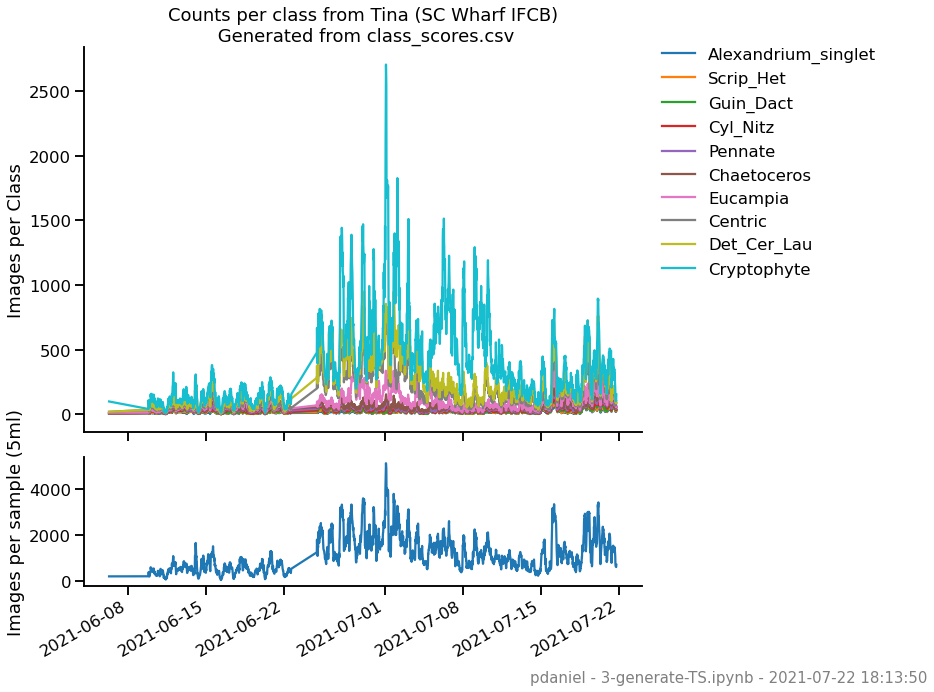

In [29]:
sns.set_context('talk')
fig, (ax,ax2) = plt.subplots(2,constrained_layout=False, gridspec_kw={'height_ratios': [3, 1]})
plt.subplots_adjust(hspace=.1)
fig.set_size_inches(10,11)

p1 = df[top_cols].plot(ax=ax,)
ax.legend(bbox_to_anchor=(1.01, 1.04), loc='upper left',frameon=False)
ax.set_ylabel("Images per Class")

ax2.plot(df['dateTime'], df['nsamples'])
ax2.set_ylabel("Images per sample (5ml)")
fig.autofmt_xdate()

ax.set_title("Counts per class from Tina (SC Wharf IFCB)\n Generated from class_scores.csv")

ax2.text(.8,
         -.65,
         'pdaniel - 3-generate-TS.ipynb - {}'.format(str(dt.datetime.now())[:-7]),
         transform=ax.transAxes,
         fontsize='small',
         color='.5')

sns.despine()
plt.savefig('./figures/top_data.png',dpi=300,bbox_inches='tight',transparent=False)

In [22]:
df_norm = df[column_names].divide(df['nsamples'],axis=0)

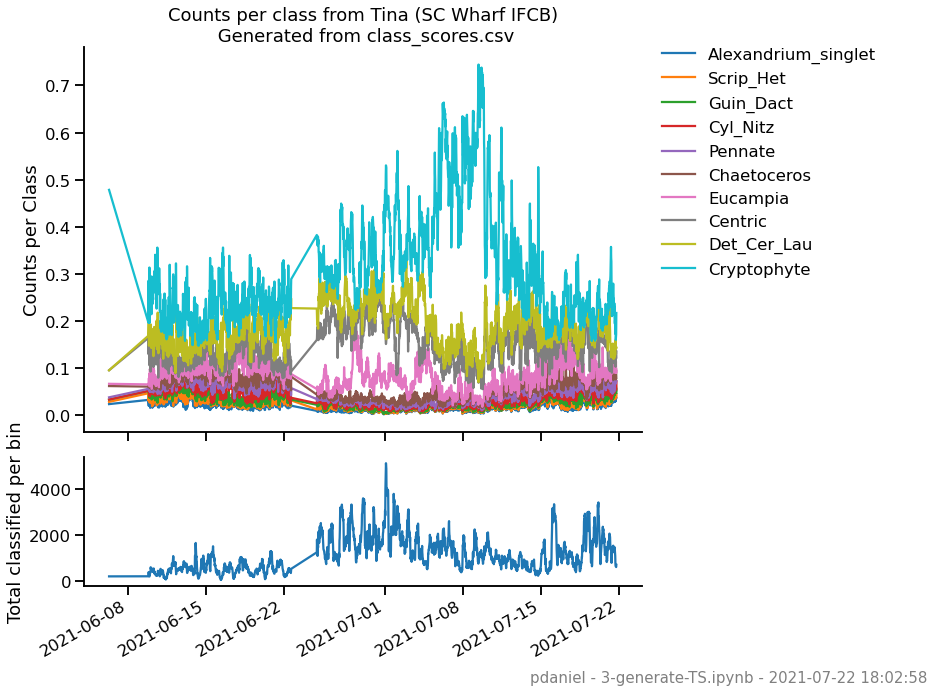

In [23]:
sns.set_context('talk')
fig, (ax,ax2) = plt.subplots(2,constrained_layout=False, gridspec_kw={'height_ratios': [3, 1]})
plt.subplots_adjust(hspace=.1)
fig.set_size_inches(10,11)

p1 = df_norm[top_cols].plot(ax=ax,)
ax.legend(bbox_to_anchor=(1.01, 1.04), loc='upper left',frameon=False)
ax.set_ylabel("Counts per Class")

ax2.plot(df['dateTime'], df['nsamples'])
ax2.set_ylabel("Total classified per bin")
fig.autofmt_xdate()

ax.set_title("Counts per class from Tina (SC Wharf IFCB)\n Generated from class_scores.csv")

ax2.text(.8,
         -.65,
         'pdaniel - 3-generate-TS.ipynb - {}'.format(str(dt.datetime.now())[:-7]),
         transform=ax.transAxes,
         fontsize='small',
         color='.5')

sns.despine()
plt.savefig('./figures/top_data_normal.png',dpi=300,bbox_inches='tight',transparent=False)

Text(0, 0.5, 'Counts per Class')

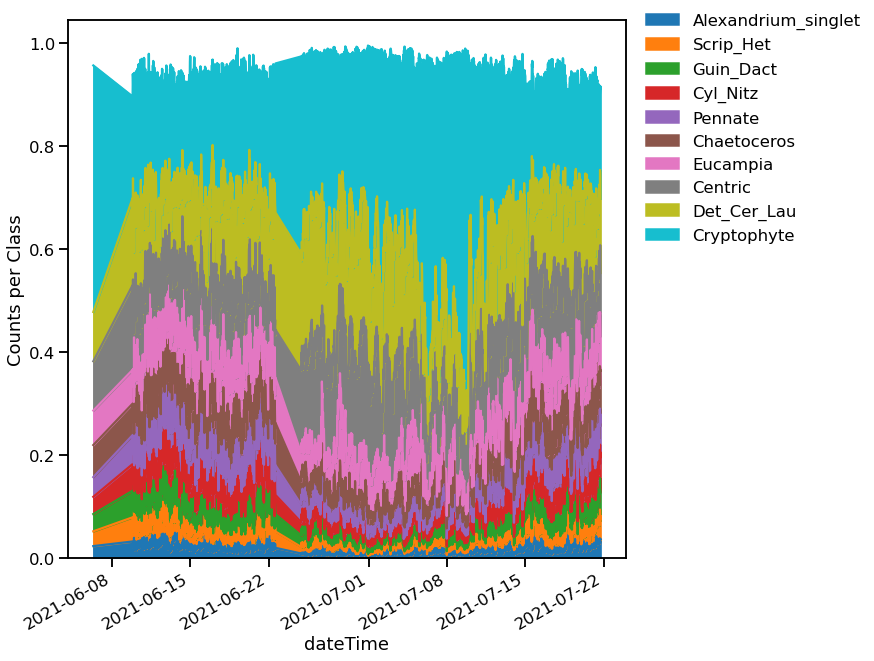

In [25]:
fig, ax = plt.subplots()
fig.set_size_inches(10,11)

df_norm[top_cols].plot.area(ax=ax)

ax.legend(bbox_to_anchor=(1.01, 1.04), loc='upper left',frameon=False)
ax.set_ylabel("Counts per Class")



In [26]:
new_index = pd.date_range(start=df['dateTime'].iloc[0],end=df['dateTime'].iloc[-1],freq="23T44S")
df_reindexed = df_norm.reindex(new_index,method="nearest",tolerance='25min',limit=2)

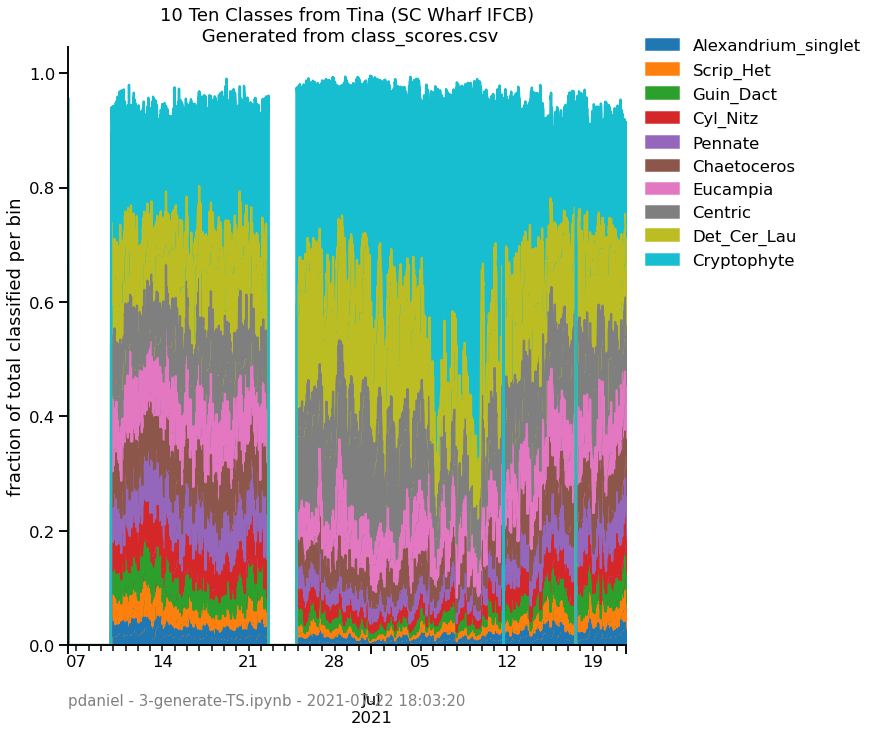

In [27]:
fig, ax = plt.subplots()
fig.set_size_inches(10,11)

df_reindexed[top_cols].plot.area(ax=ax,cmap="tab10")

ax.legend(bbox_to_anchor=(1.01, 1.04), loc='upper left',frameon=False)
ax.set_ylabel("fraction of total classified per bin")
ax.set_xlim(df_reindexed.index[0],df_reindexed.index[-1]);
ax.set_title("10 Ten Classes from Tina (SC Wharf IFCB)\n Generated from class_scores.csv")

ax.text(0,
         -.1,
         'pdaniel - 3-generate-TS.ipynb - {}'.format(str(dt.datetime.now())[:-7]),
         transform=ax.transAxes,
         fontsize='small',
         color='.5')

sns.despine()
plt.savefig('./figures/top_data_stacked_normal.png',dpi=300,bbox_inches='tight',transparent=False)


## Load Whaft Shore Station ##

In [21]:
shore = pd.read_csv('./data/210609.csv',skiprows=[1])
shore['dateTime'] = pd.to_datetime(shore["Date Time"])
shore.index = shore['dateTime']
shore2 = pd.read_csv('./data/210622.csv',skiprows=[1])
shore2['dateTime'] = pd.to_datetime(shore2["Date Time"])
shore2.index = shore2['dateTime']
shore = pd.concat((shore,shore2))


<AxesSubplot:xlabel='dateTime'>

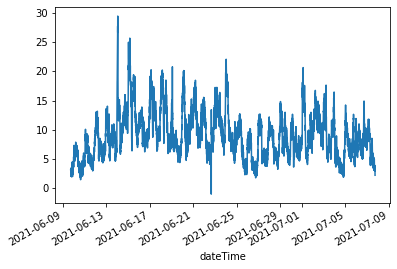

In [23]:
shore['Chl'].plot()

Text(-0.1, -0.4, 'pdaniel - 3-generate-TS.ipynb - 2021-07-22 23:22:57')

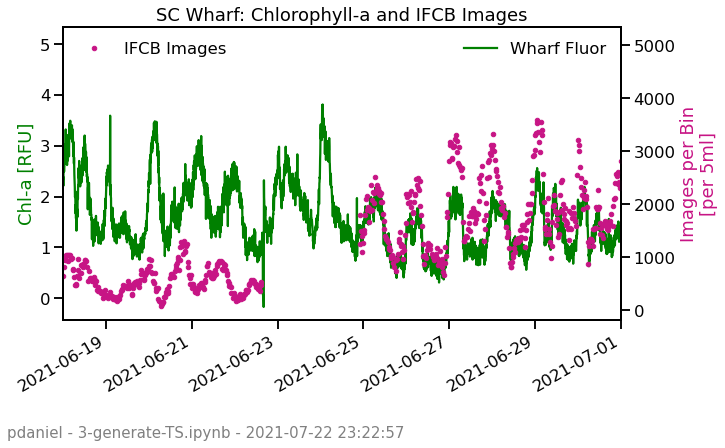

In [82]:
sns.set_context('talk')
fig,ax = plt.subplots()
fig.set_size_inches(10,6)
ax2 = ax.twinx()
ax2.plot(df['dateTime'], df['nsamples'], c='#C71585',lw=0,marker='.',label='IFCB Images')
ax2.set_ylabel('Images per Bin\n[per 5ml]',color = "#C71585")
ax.plot(shore['dateTime'], shore['Chl.1'],color='g',label='Wharf Fluor')
ax.set_ylabel('Chl-a [RFU]', color='g')
ax.legend(fancybox=False, loc=1,frameon=False)
ax2.legend(fancybox=False, loc=2 ,frameon=False)
fig.autofmt_xdate()
ax.set_xlim(dt.datetime(2021,6,18),dt.datetime(2021,7,1))
ax2.set_xlim(dt.datetime(2021,6,18),dt.datetime(2021,7,1))


plt.title("SC Wharf: Chlorophyll-a and IFCB Images")
ax.text(-.1,
         -.4,
         'pdaniel - 3-generate-TS.ipynb - {}'.format(str(dt.datetime.now())[:-7]),
         transform=ax.transAxes,
         fontsize='small',
         color='.5')

# sns.despine()

Text(-0.1, -0.4, 'pdaniel - 3-generate-TS.ipynb - 2021-07-22 23:21:25')

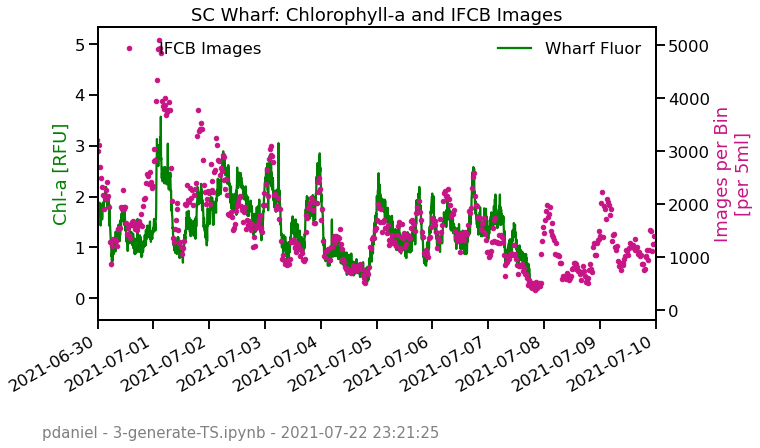

In [81]:
sns.set_context('talk')
fig,ax = plt.subplots()
fig.set_size_inches(10,6)
ax2 = ax.twinx()
ax2.plot(df['dateTime'], df['nsamples'], c='#C71585',lw=0,marker='.',label='IFCB Images')
ax2.set_ylabel('Images per Bin\n[per 5ml]',color = "#C71585")
ax.plot(shore['dateTime'], shore['Chl.1'],color='g',label='Wharf Fluor')
ax.set_ylabel('Chl-a [RFU]', color='g')
ax.legend(fancybox=False, loc=1,frameon=False)
ax2.legend(fancybox=False, loc=2 ,frameon=False)
fig.autofmt_xdate()
ax.set_xlim(dt.datetime(2021,6,30),dt.datetime(2021,7,10))
ax2.set_xlim(dt.datetime(2021,6,30),dt.datetime(2021,7,10))


plt.title("SC Wharf: Chlorophyll-a and IFCB Images")
ax.text(-.1,
         -.4,
         'pdaniel - 3-generate-TS.ipynb - {}'.format(str(dt.datetime.now())[:-7]),
         transform=ax.transAxes,
         fontsize='small',
         color='.5')

# sns.despine()